In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video

In [3]:
def get_interpolated(array, index):
    pass

In [4]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    next_psi = np.zeros((n, n), dtype=np.complex_)
    
    # potential-part
    next_psi = [[psi[i, j] * np.exp(1j * dt * potential[i, j]) for j in range(n)] for i in range(n)]

    next_psi = np.fft.fft2(next_psi)
    
    for i in range(n):
        for j in range(n):
            k = 2*np.pi * min(i, n-i)
            l = 2*np.pi * min(j, n-j)
            theta = (k*k + l*l) * dt
            next_psi[i, j] *= np.exp(1j * theta)
    
    next_psi = np.fft.ifft2(next_psi)
    return next_psi

In [35]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / width*width) + 0j

In [36]:
def parabolar(x, y, n, offset, factor):
    x = float(x - n//2) / (n/2.0) - offset[0]
    y = float(y - n//2) / (n/2.0) - offset[1]
    return factor * (x*x + y*y) + 0j
    

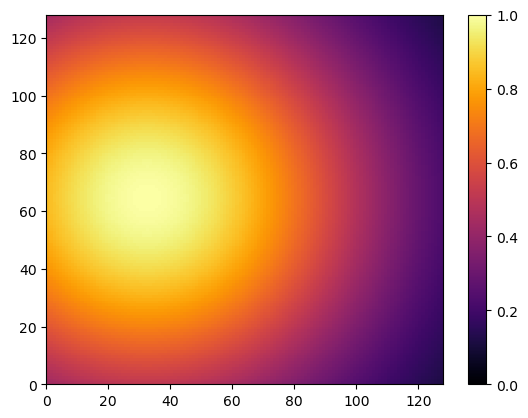

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


KeyboardInterrupt: 

In [38]:
%rm test.mp4 

frames = [] # for storing the generated images
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('test.mp4', fourcc, 12.0, (800, 600))

n = 128

psi = np.array([[gaussian(x, y, n, offset=[-0.5, 0.0], width=0.01) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=1) for x in range(n)] for y in range(n)])
frames.append(psi)

plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1, animated=True)
plt.colorbar()
plt.show()


for i in range(12*5):
    print(i)
    for timestep in range(1):
        psi = calculate_next_psi(psi, 0.0005, np.zeros((n, n)))
    frames.append(psi)



for i in range(len(frames)):
    plt.figure(figsize=(8, 6))
    plot = plt.pcolormesh(pow(np.abs(frames[i]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1, animated=True)
    plt.colorbar()
    plt.title('psi')

    # Save to temporary file
    plt.savefig('temp_frame.png')
    plt.close()

    # Read the image and add to the video
    img = cv2.imread('temp_frame.png')
    video.write(img)

video.release()

In [142]:
Video("test.mp4")